### Objective: Applying Tf-idf to the Text and then featurizing them and applying the resultant sparse matrix to Logistic Regression and Linear-SVM and finding the Log-Loss.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np


In [14]:
# avoid decoding problems
df = pd.read_csv("train.csv",nrows=100000)
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [15]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",nrows=100000,encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",nrows=100000,encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [16]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','is_duplicate'],axis=1)


In [17]:
df_1  = df1.merge(df2, on='id',how='left') # merging two data frames

In [18]:
# merging two data frames

df=df_1.merge(df3, on='id',how='left') 

In [19]:
df.columns

Index(['id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'question1',
       'question2'],
      dtype='object')

### Let us check for NaN values

In [20]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, is_duplicate, cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, question1, question2]
Index: []

[0 rows x 30 columns]


In [22]:
target = df['is_duplicate'].values
df.drop(['id','is_duplicate'], axis=1, inplace=True)

## Split Data into Train and Test Data in the ratio of 70:30

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, target, stratify=target, test_size=0.3)

In [24]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print("="*100)

(70000, 28) (70000,)
(30000, 28) (30000,)


<b> Applying TFIDF Vectorizer </b>

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['question1'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_q1_tfidf = vectorizer.transform(X_train['question1'].values)
X_test_q1_tfidf = vectorizer.transform(X_test['question1'].values)
print("After vectorizations")
print(X_train_q1_tfidf.shape, y_train.shape)
print(X_test_q1_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(70000, 5233) (70000,)
(30000, 5233) (30000,)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['question2'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_q2_tfidf = vectorizer.transform(X_train['question2'].values)
X_test_q2_tfidf = vectorizer.transform(X_test['question2'].values)
print("After vectorizations")
print(X_train_q2_tfidf.shape, y_train.shape)
print(X_test_q2_tfidf.shape, y_test.shape)
print("="*100)

After vectorizations
(70000, 28878) (70000,)
(30000, 28878) (30000,)


In [28]:
from scipy.sparse import hstack

X_train_q1q1=hstack((X_train_q1_tfidf,X_train_q2_tfidf))
X_test_q1q1=hstack((X_test_q1_tfidf,X_test_q2_tfidf))

In [29]:
X_train.drop(['question2','question1'], axis=1, inplace=True)
X_test.drop(['question2','question1'], axis=1, inplace=True)

In [31]:
X_train_final=hstack((X_train_q1q1,X_train)).tocsr()
X_test_final=hstack((X_test_q1q1,X_test)).tocsr()

In [32]:
print(X_train_final.shape, y_train.shape)
print(X_test_final.shape, y_test.shape)
print("="*100)

(70000, 34137) (70000,)
(30000, 34137) (30000,)


In [33]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    plt.show()

## Random Model

In [34]:
from collections import Counter

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in test data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


Log loss on Test Data using Random Model 0.892014151563463


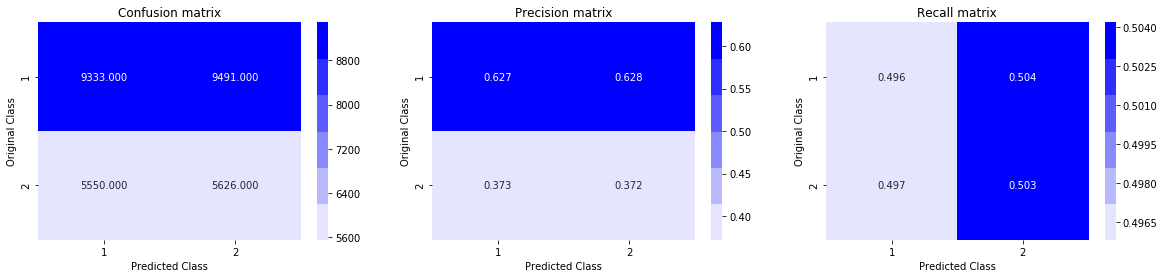

In [35]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns


predicted_y = np.zeros((len(y_test),2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<b> Observation </b> : Here, we got the log loss of '0.892014151563463'. Hence, for the other models we should get the log loss below '0.892014151563463'

# Logistics Regression with Hypertuning

For values of alpha =  1e-05 The log loss is: 0.4644253973706116
For values of alpha =  0.0001 The log loss is: 0.46475317659549087
For values of alpha =  0.001 The log loss is: 0.4635154336443664
For values of alpha =  0.01 The log loss is: 0.4683585473232505
For values of alpha =  0.1 The log loss is: 0.4645331213225823
For values of alpha =  1 The log loss is: 0.489692630717949
For values of alpha =  10 The log loss is: 0.544098692655638


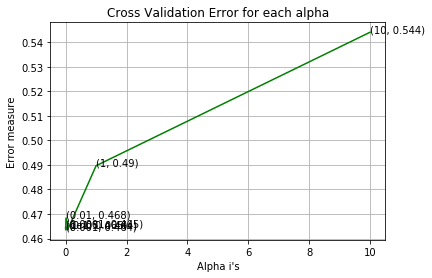

For values of best alpha =  0.001 The train log loss is: 0.4657976833249218
For values of best alpha =  0.001 The test log loss is: 0.4635154336443664
Total number of data points : 30000


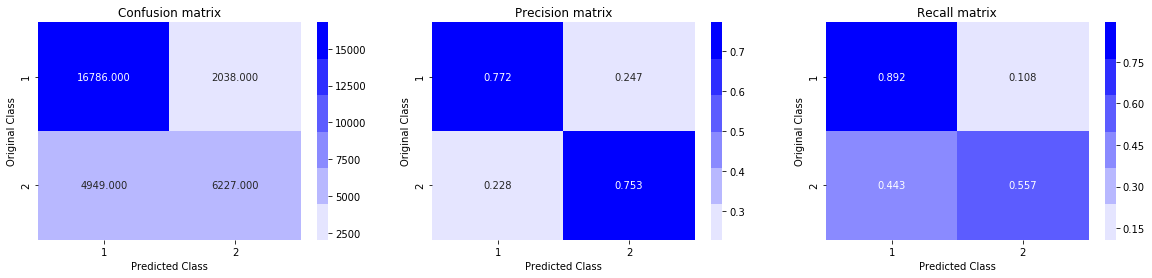

In [37]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
import seaborn as sns

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#  Linear SVM with hyperparameter tuning 

For values of alpha =  1e-05 The log loss is: 0.4807019619590062
For values of alpha =  0.0001 The log loss is: 0.4975579532689587
For values of alpha =  0.001 The log loss is: 0.5035342082682058
For values of alpha =  0.01 The log loss is: 0.5085899513767737
For values of alpha =  0.1 The log loss is: 0.4991226145804657
For values of alpha =  1 The log loss is: 0.5790477518023784
For values of alpha =  10 The log loss is: 0.639882506382827


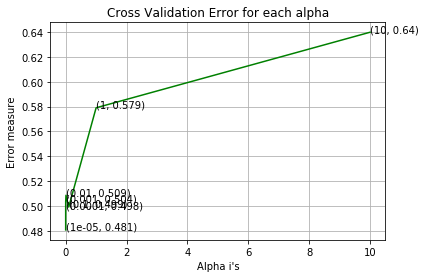

For values of best alpha =  1e-05 The train log loss is: 0.4833434750150627
For values of best alpha =  1e-05 The test log loss is: 0.4807019619590062
Total number of data points : 30000


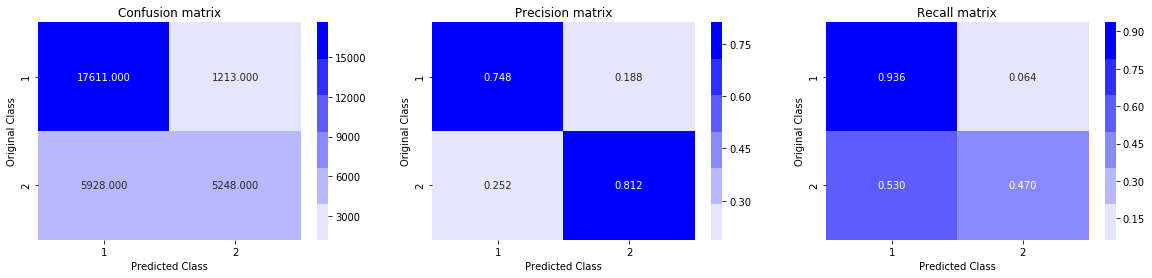

In [38]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Summary: 

<h3>Steps for model implementation :</h3>

1. Here, we have considered only 100k data points.
2. We have applied TD-IDF to feature 'question1' and 'question2'.
3. After that we have stacked it with calculated feature after pre-processing(this includes handling null values, removing unnecessary features.
4. We compressed sparse matrix to Compressed-Spase-Row(csr)
5. Using train_test_split we have split the data into train and test data in the ratio of 70:30.
6. We have applied Logistic Regression and Linear SVM on the sparse matrix.
7. From the above analysis, we can conclude Logistics Regression perfroms better as comparision to Linear-SVM.

<h1> Observations </h1>

In [1]:
from prettytable import PrettyTable    
x = PrettyTable()
x.title = " Model Comparision "
x.field_names = ["Model","vectorizer","Hyperparameter Tunning","Test log loss"]
x.add_row(['Random','TFIDF','NA','0.89201'])
x.add_row(['Logistic regression','TFIDF','Done','0.46351'])
x.add_row(['Linear SVM','TFIDF','Done','0.48070'])

print(x)

+---------------------+------------+------------------------+---------------+
|        Model        | vectorizer | Hyperparameter Tunning | Test log loss |
+---------------------+------------+------------------------+---------------+
|        Random       |   TFIDF    |           NA           |    0.89201    |
| Logistic regression |   TFIDF    |          Done          |    0.46351    |
|      Linear SVM     |   TFIDF    |          Done          |    0.48070    |
+---------------------+------------+------------------------+---------------+
